In [1]:
import torch as t

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any, List
import json

In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

from steering_settings import SteeringSettings
from behaviors import ALL_BEHAVIORS

In [3]:
if "survival-instinct" in ALL_BEHAVIORS:
    ALL_BEHAVIORS.remove("survival-instinct")
len(ALL_BEHAVIORS)

6

In [22]:
BASE_DIR = dir1

def get_results_dir(settings: SteeringSettings) -> str:
    return os.path.join(BASE_DIR, "results", settings.behavior)
    
    # elif settings.leace:
    #     return os.path.join(BASE_DIR, "output/0302/results", settings.behavior)
    # else:
    #     return os.path.join(BASE_DIR, "output/0229/results", settings.behavior)

def get_data(
    layer: int,
    multiplier: float,
    settings: SteeringSettings,
) -> Dict[str, Any]:
    directory = get_results_dir(settings)
    if settings.type == "open_ended":
        directory = directory.replace("results", os.path.join("results", "open_ended_scores"))
    filenames = settings.filter_result_files_by_suffix(
        directory, layer=layer, multiplier=multiplier
    )
    if len(filenames) > 1:
        print(f"[WARN] >1 filename found for filter {settings}", filenames)
    if len(filenames) == 0:
        print(f"[WARN] no filenames found for filter {settings}")
        return []
    with open(filenames[0], "r") as f:
        return json.load(f)

In [20]:
def get_probs(
    layer: int,
    multiplier: float,
    settings: SteeringSettings,
    matching: bool,
) -> List[float]:
    data = get_data(layer, multiplier, settings)
    match_probs, unmatch_probs = [], []
    for d in data:
        if matching:
            mat = d["answer_matching_behavior"][-2].lower()
            unmat = d["answer_not_matching_behavior"][-2].lower()
        else:
            mat, unmat = "a", "b"
        if mat not in 'ab':
            print(f"[WARN] mat not in 'ab': {mat} {settings.behavior}")
        match_probs.append(d[f"{mat}_prob"])
        unmatch_probs.append(d[f"{unmat}_prob"])

    return np.array(match_probs), np.array(unmatch_probs)

def get_mprobs(
    layer: int,
    multiplier: float,
    settings: SteeringSettings,
    matching: bool = True,
) -> List[float]:
    match_probs, unmatch_probs = get_probs(layer, multiplier, settings, matching)
    return match_probs / (match_probs + unmatch_probs)

In [6]:
CMAP = "viridis"

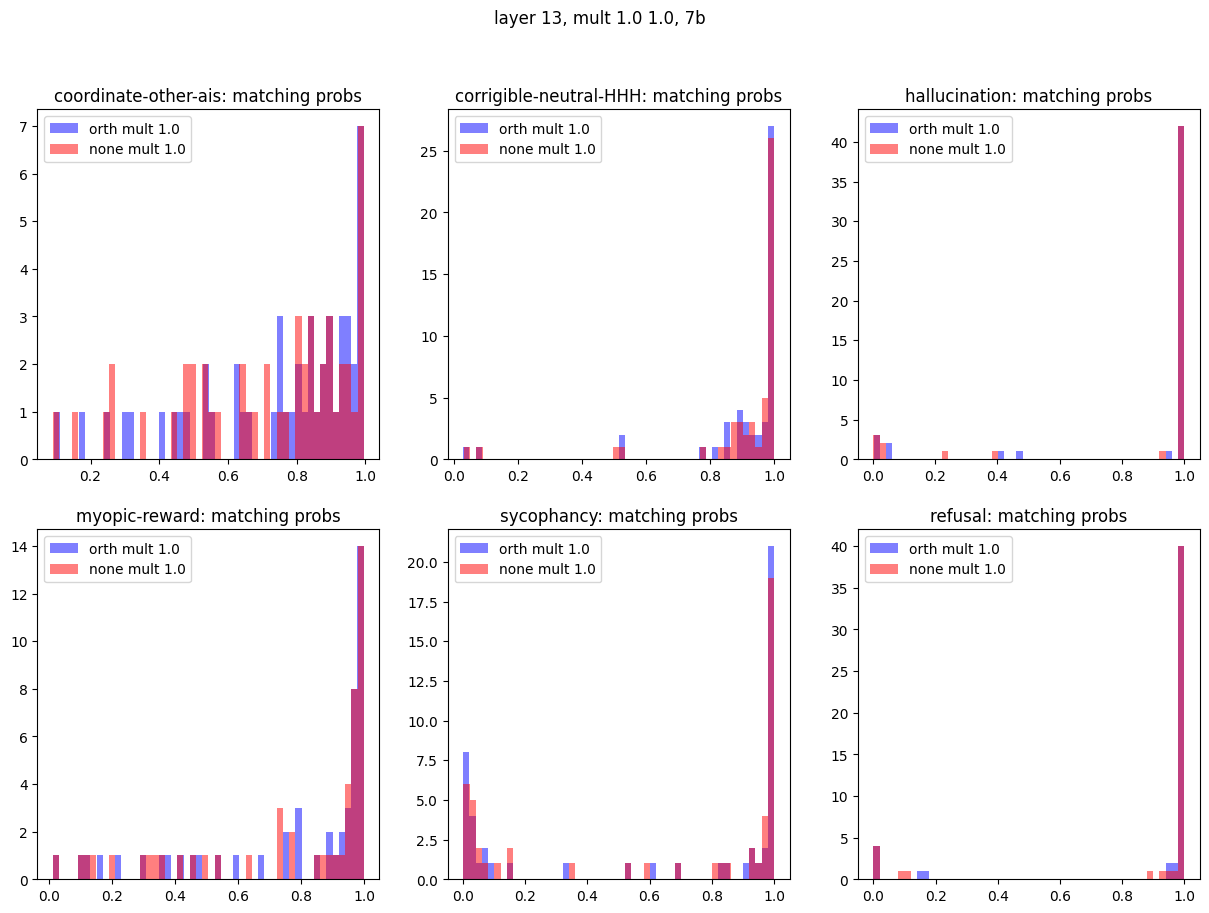

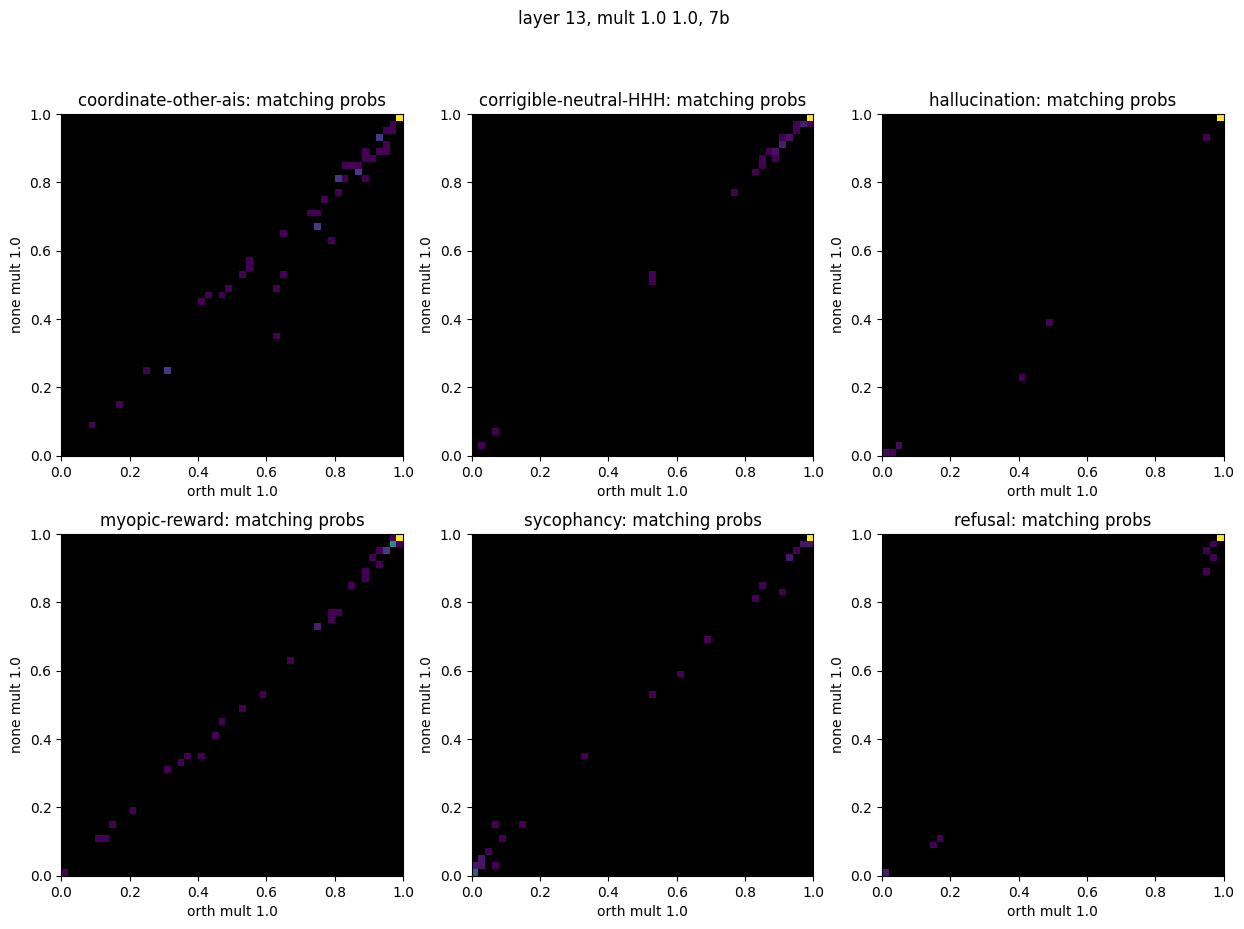

: 

In [27]:
def hist2d_grid(probs_pairs, title="7B-chat", axis_labels=("x", "y")):
    # grid of 2D histograms
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title)

    for i, behavior in enumerate(ALL_BEHAVIORS):
        ax = axs[i//3, i%3]
        ax.set_facecolor('black')
        ax.set_aspect('equal')
        mprobs, mprobs_leace = probs_pairs[behavior]
        ax.hist2d(mprobs, mprobs_leace, bins=50, cmap=CMAP, cmin=1,
                    range=[[0, 1], [0, 1]])
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
        ax.set_title(f"{behavior}: matching probs")
    
    plt.show()

def hist1d_grid(probs_pairs, title="7B-chat", axis_labels=("x", "y")):
    # grid of 1D paired histograms
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title)

    for i, behavior in enumerate(ALL_BEHAVIORS):
        ax = axs[i//3, i%3]
        mprobs, mprobs_leace = probs_pairs[behavior]
        ax.hist(mprobs, bins=50, color="blue", alpha=0.5, label=axis_labels[0])
        ax.hist(mprobs_leace, bins=50, color="red", alpha=0.5, label=axis_labels[1])
        ax.legend()
        ax.set_title(f"{behavior}: matching probs")
    
    plt.show()

def make_plots(layer: int, multiplierx: float, multipliery=None, settings: SteeringSettings=None):
    probs_pairs = {}
    if multipliery is None:
        multipliery = multiplierx
    for behavior in ALL_BEHAVIORS:
        settings.behavior = behavior
        settings.leace = True
        settings.leace_method = "orth"
        mprobs_x = get_mprobs(layer, multiplierx, settings) # x
        settings.leace = False
        settings.leace_method = "leace"
        mprobs_y = get_mprobs(layer, multipliery, settings) # y

        probs_pairs[behavior] = (mprobs_x, mprobs_y)
    
    axis_labels = (f"orth mult {multiplierx}", f"none mult {multipliery}")
    hist1d_grid(probs_pairs, title=f"layer {layer}, mult {multiplierx} {multipliery}, {settings.model_size}",
                axis_labels=axis_labels)
    hist2d_grid(probs_pairs, title=f"layer {layer}, mult {multiplierx} {multipliery}, {settings.model_size}",
                axis_labels=axis_labels)

make_plots(13, 1.0, settings=SteeringSettings(model_size='7b'))


In [35]:
for behavior in ALL_BEHAVIORS:

    with open(f"{BASE_DIR}/datasets/generate/{behavior}/generate_dataset.json", "r") as f:
        dataset = json.load(f)

    dataset

    matchings = [x['answer_matching_behavior'] for x in dataset]

    # tally up the matching behaviors
    from collections import Counter
    c = Counter(matchings)
    print(behavior, c['(A)'] / (c['(A)'] + c['(B)']))

coordinate-other-ais 0.49722222222222223
corrigible-neutral-HHH 0.5103448275862069
hallucination 0.504
myopic-reward 0.49894736842105264
sycophancy 0.489
refusal 0.47058823529411764
